In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
path = os.getcwd() 
print(path)
PATH = path + "/pytorch_sample/data"

import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

def seed_everything(seed = 42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'Seed set = {seed}')
    
seed_everything()

c:\Users\bm990\Desktop\백업\Python_Code\DL\Paper
cuda is available
Seed set = 42


Setting Hyperparameters

In [2]:
batch_size_ = 32
learning_rate_ = 1e-3
epoch_ = 10

Load data

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32, 32)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root=PATH, train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(dataset, [40000, 10000])
trainloader = DataLoader(trainset, batch_size=batch_size_, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size_, shuffle=False)

testset = torchvision.datasets.CIFAR10(root=PATH, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size_, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Model architecture

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, bias=True), #C1
            nn.AvgPool2d(kernel_size=2, stride=2), nn.Tanh(), #S2
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5), #C3
            nn.AvgPool2d(kernel_size=2, stride=2), nn.Tanh(), #S4
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5), nn.Tanh() #C5
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84), nn.Tanh(),#F6
            nn.Linear(84, 10) #OUTPUT
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 120)
        x = self.classifier(x)
        x = F.softmax(x, dim=1) # 원 논문에서는 Euclidean Radial Basis Function을 사용하였음.
        return x

define validation loss

In [9]:
def validaion_loss(dataloader):
    n = len(dataloader)
    running_loss = 0.0
    total = 0.0
    accuracy = 0.0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    model.train()
    accuracy = (100 * accuracy / total)
    return running_loss / n, accuracy

In [10]:
def VisualizeAccLoss(train_acc_list, val_acc_list, train_loss_list, val_loss_list, lrs):
        # Train loss, Validation loss 확인
        plt.figure(1)
        plt.plot(train_loss_list)
        plt.plot(val_loss_list)
        plt.legend(['train', 'validation'])
        plt.title("loss")
        plt.xlabel('epoch')
        plt.show()
        # Train loss, Validation loss 확인
        plt.figure(1)
        plt.plot(train_acc_list)
        plt.plot(val_acc_list)
        plt.legend(['train', 'validation'])
        plt.title("loss")
        plt.xlabel('epoch')
        plt.show()
        # Learning Rate 변화 확인
        plt.figure(3)
        plt.plot(lrs)
        plt.title('learning rate')
        plt.xlabel('epoch')
        plt.show()

Train model

[1] loss : 2.129
[1] train loss : 2.129, validation loss: 2.088, train acc : 32.835, validation acc: 37.030
[2] loss : 2.061
[2] train loss : 2.061, validation loss: 2.050, train acc : 39.553, validation acc: 40.870
[3] loss : 2.028
[3] train loss : 2.028, validation loss: 2.032, train acc : 43.072, validation acc: 42.540
[4] loss : 2.004
[4] train loss : 2.004, validation loss: 2.012, train acc : 45.502, validation acc: 44.460
[5] loss : 1.985
[5] train loss : 1.985, validation loss: 1.996, train acc : 47.502, validation acc: 46.160


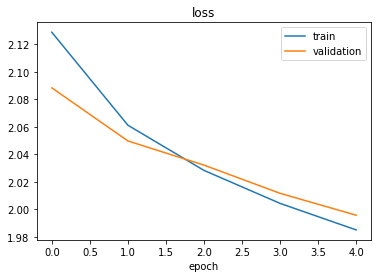

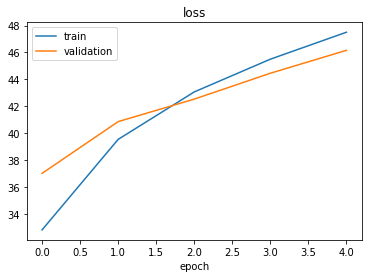

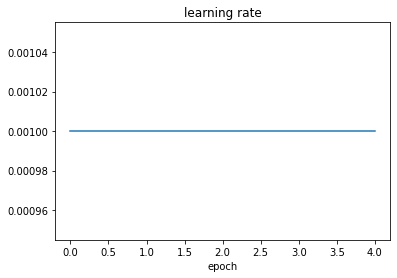

[6] loss : 1.970
[6] train loss : 1.970, validation loss: 2.000, train acc : 48.920, validation acc: 45.820
[7] loss : 1.954
[7] train loss : 1.954, validation loss: 1.985, train acc : 50.678, validation acc: 47.010
[8] loss : 1.940
[8] train loss : 1.940, validation loss: 1.977, train acc : 52.047, validation acc: 48.070
[9] loss : 1.929
[9] train loss : 1.929, validation loss: 1.977, train acc : 53.335, validation acc: 47.970
[10] loss : 1.921
[10] train loss : 1.921, validation loss: 1.976, train acc : 54.115, validation acc: 48.190


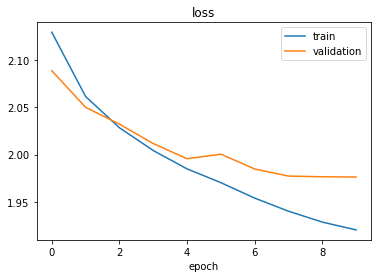

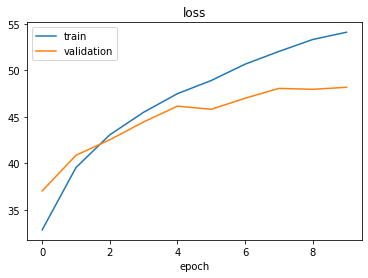

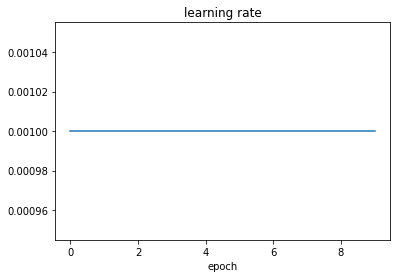

In [21]:

criterion = nn.CrossEntropyLoss()
model = LeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate_)

train_loss_list,val_loss_list = [],[]
train_acc_list, val_acc_list = [],[]
lrs = []
early_stopping_val_acc = 88

n = len(trainloader)
for epoch in range(epoch_):
    running_loss = 0.0
    total = 0.0
    accuracy = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        accuracy += (predicted == labels).sum().item()
        optimizer.step()
        running_loss += loss.item()
        total += labels.size(0)
        
    print('[%d] loss : %.3f'%(epoch + 1, running_loss / len(trainloader)))
    
    
    accuracy = (100 * accuracy / total)
        
    train_loss = running_loss / n
    train_loss_list.append(train_loss)
    val_loss, val_accuracy = validaion_loss(valloader)
    val_loss_list.append(val_loss)
    train_acc_list.append(accuracy)
    val_acc_list.append(val_accuracy)
    
    lrs.append(optimizer.param_groups[0]["lr"])
    print('[%d] train loss : %.3f, validation loss: %.3f, train acc : %.3f, validation acc: %.3f'
          %(epoch + 1, train_loss, val_loss, accuracy, val_accuracy))
    
    # 중간에 Loss가 어떻게 되어가는지 확인
    if (epoch + 1) % 5 == 0:
        VisualizeAccLoss(train_acc_list, val_acc_list, train_loss_list, val_loss_list, lrs)
    
    # Validation accuracy가 Maximum이 되는 지점을 탐색
    if val_accuracy > early_stopping_val_acc:
            
        torch.save(model.state_dict(), PATH
                    + '_val_acc_' + str(val_accuracy) + '.pt')
        early_stopping_val_acc = val_accuracy
        early_stopping_epoch = epoch

In [24]:
PATH2 = path + 'Pytorch_sample/models/cifar_alexnet.pth'
import os
os.makedirs(path+'Pytorch_sample/models/',exist_ok=True)
torch.save(model.state_dict(),PATH2)

model = LeNet().to(device)
model.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

Evaluate model

In [25]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
print('Test accuract:%.2f%%'%(100 * correct/total))

Test accuract:48.91%
